# Bagging: Bootstrap Aggregating and Random Forest

This is your first lesson dedicated to **ensemble methods** and **meta-learning**. In this session, we focus on **Bagging**, a powerful technique that applies the **same learner** to multiple **resampled versions** of the training data, and then combines their predictions. The final output is obtained by **averaging** (for regression) or **majority voting** (for classification).

By the end of this lesson, you should be able to:

- Understand the **limitations** of predictive models such as Decision Trees.
- Explain how combining the same learner over different resampled datasets can **improve predictive performance**.
- See how introducing **randomness in feature selection** — the key idea behind **Random Forests** — further improves **generalization**.


## 1. Introduction: Decision tree

Let's start this lesson generating some toy data for classification.

In [1]:
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

import matplotlib.pyplot as plt

X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=42, class_sep=0.15, flip_y=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In DS-3001, you already learned about Decision Trees.

Just to refresh your memory: Decision Trees are predictive methods used for both classification and regression. They work by **splitting the data** based on a **decision rule** applied to **a single feature at a time**.

What determines which feature to split on? It is the one that leads to the best quality of the data after the split.

For example, if we are doing binary classification, and splitting the data on a certain feature results in two subgroups (nodes) where each group contains mostly one class label, then that is a good split. It is better than a split where both groups are still a mix of labels.

Decision Trees continue splitting the data until a stopping criterion is met. Typically, this happens when there are no more useful splits — for instance, when all observations in a node belong to the same class or there are too few samples left to split meaningfully.

Since Decision Trees are based on decision rules rather than learning fixed parameters, they are considered **non-parametric** methods.

They can be very powerful — and the best part is, they are highly interpretable. You can simply look at the different splits throughout the tree to understand which features matter and why the model is making its predictions.

In `scikit-learn` this method is implemented through the `DecisionTreeClassifier` and `DecisionTreeRegressor` classes.

In [2]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
clf = DecisionTreeClassifier(random_state=1234)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1234)

Let's explore the obtained tree:

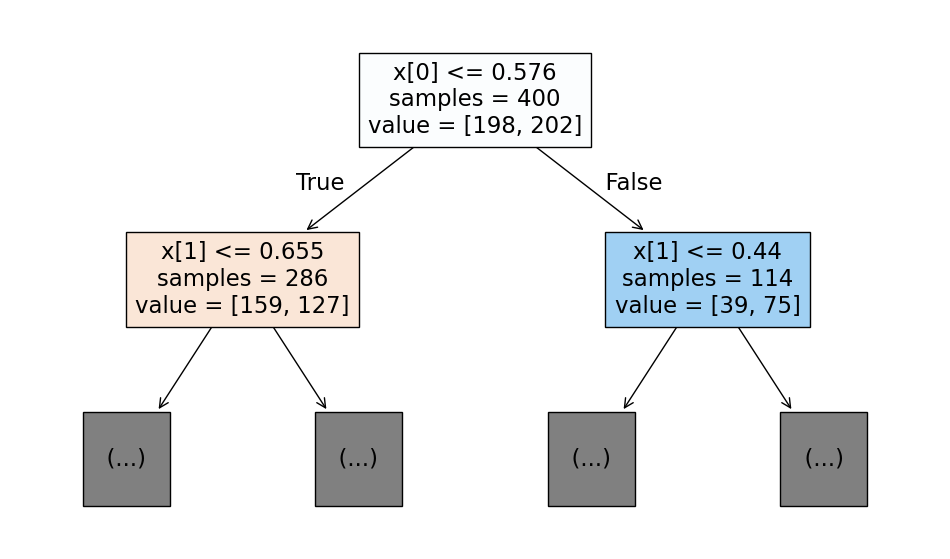

In [3]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,7))
plot_tree(clf, filled=True, max_depth=1, impurity=False)
plt.show()

<div class="alert alert-danger"> 

🚨🚨**HOWEVER**🚨🚨
    
A single Decision Tree is generally unstable, because it is highly sensitive to small changes in the training data. Even small variations in the data can lead to very different tree structures, making predictions vary significantly if we train the model on different subsets of the data.
</div>

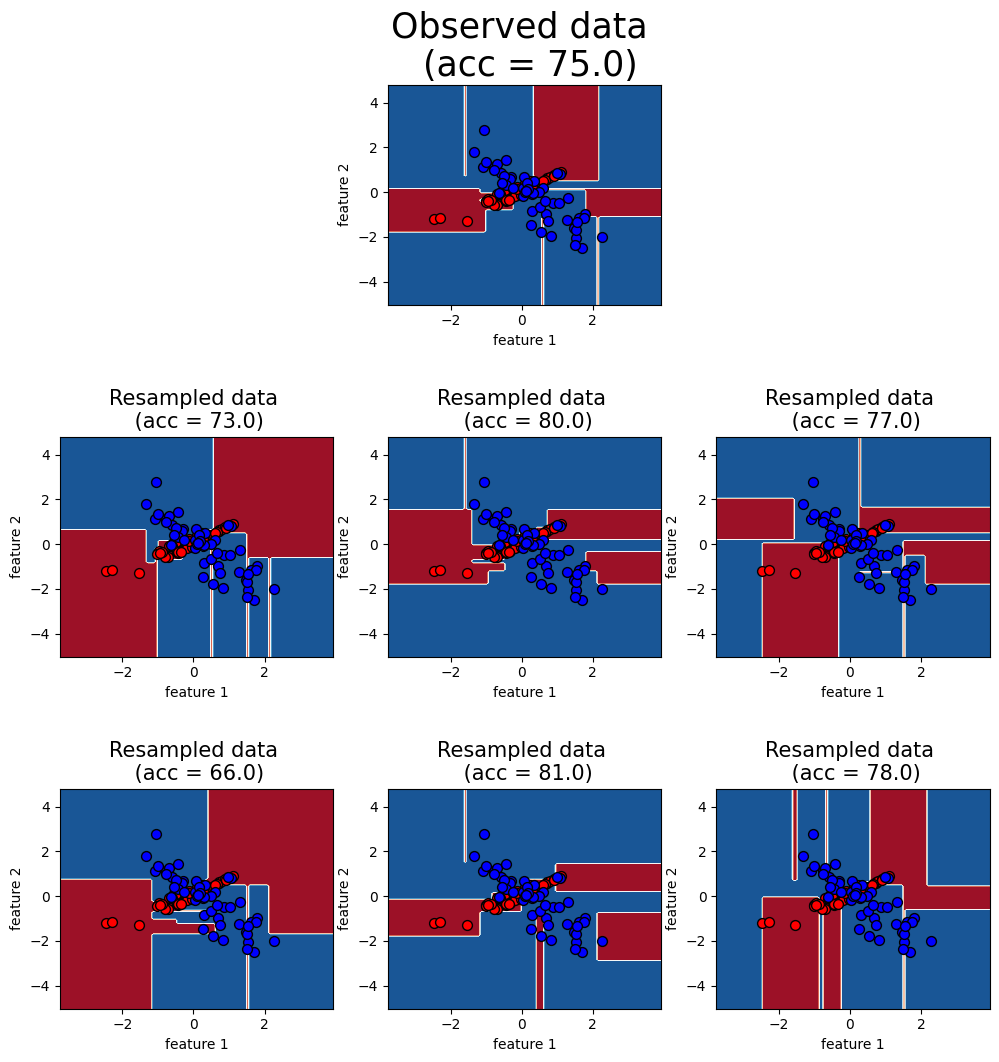

In [4]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 12))  
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.6)  
ax = fig.add_subplot(gs[0, 1])  

clf = DecisionTreeClassifier(random_state=1234)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
DecisionBoundaryDisplay.from_estimator(clf, 
                                       X_train, 
                                       cmap=plt.cm.RdBu, 
                                       response_method="predict", 
                                       ax=ax, 
                                       xlabel="feature 1", 
                                       ylabel="feature 2")

ax.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c="r", edgecolor="black", s=50)
ax.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c="b", edgecolor="black", s=50)
ax.set_title(f"Observed data \n (acc = {acc*100:.1f})", size=25)

for i in range(6):
    row = (i // 3) + 1  # rows 1 to 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col])
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    clf.fit(X_resampled, y_resampled)
    acc = clf.score(X_test, y_test)

    DecisionBoundaryDisplay.from_estimator(clf, X_train, cmap=plt.cm.RdBu, response_method="predict",
                                           ax=ax,
                                           xlabel="feature 1",
                                           ylabel="feature 2")

    ax.scatter(X_test[y_test==0][:,0], X_test[y_test==0][:,1], c="r", edgecolor="black", s=50)
    ax.scatter(X_test[y_test==1][:,0], X_test[y_test==1][:,1], c="b", edgecolor="black", s=50)
    ax.set_title(f"Resampled data \n (acc = {acc*100:.1f})", size=15)

You can see how unstable the decision boundaries — and therefore the prediction accuracy — can be.

But you might be wondering: *Why do we not just stick to the data we have? Why do we need to look at different “copies” of the data?*

Because:

- In the real world, there is always an element of randomness or noise, which you might miss if you only rely on **one model** trained on a **fixed dataset**.
- We want the model to **account for these random variations** and still perform well — not just on the training data, but more generally.
- Put another way: in statistics, we use **bootstrapping** to simulate different samples from the real world, not just the one dataset we happen to observe. The idea here is similar — we create different versions of the data to build more **robust** and **realistic** models.

This motivates the idea of **bagging**.

## 2. Bagging

**Bagging** is short for **Bootstrap Aggregating**. Instead of training a single unstable model, bagging involves training many models on different bootstrapped samples of the data. Then, predictions are made based on the output of all the models combined. This approach reduces variance and leads to more robust and stable predictions.

Let's fit 50 decision trees on different version of the data by bootstrapping


In [5]:
n_estimators = 50

estims = []
for ii in range(n_estimators):
    X_resampled, y_resampled = resample(X_train, y_train, random_state=ii)
    clf = DecisionTreeClassifier(random_state=1234)
    clf.fit(X_resampled, y_resampled)
    estims.append(clf)

We can make predictions using each decision tree:

In [6]:
X_preds = np.column_stack([estim.predict(X_test) for estim in estims])
X_preds.shape

(100, 50)

Let's look at one example:

In [7]:
X_preds[0,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In this observation, all the decision trees but one assign the label 1, so we would trust this label.

We then assign each observation the label chosen by the majority of the trees (welcome, democracy!).

In [8]:
preds_counts = np.zeros(X_test.shape)

# Iterate through each row of the array
for ii, row in enumerate(X_preds):
    preds_counts[ii, 0] = sum(row==0)
    preds_counts[ii, 1] = sum(row==1)
# THe first 5 observations
preds_counts[:5]

array([[ 1., 49.],
       [35., 15.],
       [ 0., 50.],
       [14., 36.],
       [39., 11.]])

Like we said, we assign the label chosen by the majority:

In [9]:
y_pred = np.argmax(preds_counts, axis=1)

In [10]:
accuracy_score(y_test, y_pred)

0.85

Compare to using just one decision tree:

In [11]:
clf = DecisionTreeClassifier(random_state=1234)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.75

In regression, since we don't have labels but continuos data, what we do is average the predictions.

This that we have done manually, you can do it in `scikit-learn` through the `BaggingClassifier` and `BaggingRegressor` classes.

In [12]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1234), 
                        n_estimators=50, random_state=12)
bagging_clf.fit(X_train, y_train)
accuracy_score(y_test, bagging_clf.predict(X_test))

0.85

<div class="alert alert-info"> 

𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓

Bagging is a concept, meaning it can be applied to **any** estimator, not just decision trees.

</div>

In [13]:
from sklearn.linear_model import LogisticRegression
baggin_logReg = BaggingClassifier(estimator=LogisticRegression(), 
                        n_estimators=50, random_state=12)
baggin_logReg.fit(X_train, y_train)
accuracy_score(y_test, baggin_logReg.predict(X_test))

0.66

### Out-of-Bag (OOB) Error

One of the cool advantages of bagging is that we can estimate the model's prediction performance **without using a separate validation set**. This is done using the **Out-of-Bag (OOB) Error**.

When creating bootstrapped samples, some observations from the original dataset are **left out** in each sample (on average, about 1/3 of the data). These unused observations are called **out-of-bag samples**.

We can use these OOB samples to evaluate the model trained on the corresponding bootstrap sample:

- For each observation, we collect predictions **only from the models that did not see it during training**.
- We then compare the aggregated prediction to the true value.

This gives us an **OOB error estimate**, which serves as a reliable proxy for test error.

In `scikit-learn`, you can allow this by setting the parameter `oob_score` to True.

In [14]:
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1234), 
                                n_estimators=50, random_state=12, oob_score=True)

bagging_clf.fit(X, y)
bagging_clf.oob_score_

0.804

#### Discussion: Is Out-of-Bag (OOB) Error Enough?

Out-of-Bag error gives us a way to estimate model performance *without* needing a separate validation or test set. But is it always enough?

Let's have 5 minutes to think about:

- What are the **advantages** of using OOB error?
- What are the **potential limitations**?
- Can you think of situations where you would still prefer to have a separate **test set**?
- Would you report OOB error as your final performance metric in a published study or production setting? Why or why not?


### Feature Importance in Bagging

You probably learned that in decision trees you get a measure of feature importance, which is based on how much a feature **reduces impurity** (such as Gini, entropy, or mean squared error) when it is used to split the data.

When applying bagging to decision trees, since we train **multiple trees** and each tree provides its own estimate of feature importance, we can **average** these importance scores across all the trees. This gives us a **more stable and reliable estimate** of which features are most influential.

In [15]:
importances = np.mean([
    tree.feature_importances_ for tree in bagging_clf.estimators_
], axis=0)

importances

array([0.38722035, 0.61277965])

## 3. Random Forest: Bagging + Randomness in Features

We have just seen that **bagging** improves model stability and performance by training multiple models on different bootstrapped samples.

But what if we inject **even more randomness**, this time in the features? That is exactly what **Random Forests** do.

A **Random Forest** applies **bagging** to decision trees, but with one key difference: at each split in the tree, only a **random subset of features** is considered, rather than all features.

Why doing this?

- To **decorrelate the trees**, so they make more independent errors.
- To **reduce overfitting** even further.
- To improve **predictive performance** in many cases.

In summary, a Random Forest is an extension of bagging where randomness is introduced not only in the data (through bootstrapping) but also in the features.

In `scikit-learn`, you can use `ensemble.RandomForestClassifier` or `ensemble.RandomForestRegressor`.

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Define the classifer
rf_clf = RandomForestClassifier(n_estimators=50, random_state=1234)

# Fit to the training data
rf_clf.fit(X_train, y_train)

# Predict
rf_clf.score(X_test, y_test)

0.87

### How many random features? 

We mentioned that at each split, a **random subset of features** (instead of all features) is chosen to determine the best split. But how many random features should we select at each split?

Remember:

- If **all features** are always considered, the trees tend to become **more similar** to each other (more correlated).
- Limiting the number of features at each split makes the trees **more diverse**.

Therefore, **diversity is crucial** for reducing variance and improving generalization.

In `scikit-learn`, this is controlled by the `max_features` parameter.

So, how many features should we select?  

There is no one-size-fits-all rule. For some datasets, encouraging more diversity (smaller subsets of features) might lead to better performance. For others, using more features may work better.

As always, this is a **hyperparameter to tune via cross-validation!**

### Feature Importance in Random Forest

Explainability in Random Forests is an inherent property, since they are built on decision trees.

As mentioned earlier, in a decision tree feature importance scores reflect how much each feature contributes to **reducing impurity** (such as Gini or MSE). In Random Forest, this would be across the entire ensemble.

In `scikit-learn`, the attribute `feature_importances_` automatically **averages the importance scores across all trees** in the forest, giving you a single importance value for each feature.

In [17]:
rf_clf.feature_importances_

array([0.39320268, 0.60679732])

## 4. Summary

- **Decision Trees** are unstable models, meaning that small changes in the data can lead to very different trees. They also tend to **overfit** the training data if not properly constrained.

- **Bagging (Bootstrap Aggregating)** improves model performance by training multiple models on different **bootstrapped samples** of the data and then **aggregating** their predictions (e.g., majority vote or average). This reduces **variance** and leads to more **robust** predictions.

- **Out-of-Bag (OOB) Error** provides an internal estimate of generalization performance using only the training data, removing the need for a separate validation set.

- **Random Forests** extend Bagging by adding further randomness in the **features**: at each split in a tree, only a **random subset of features** is considered. This decorrelates the trees, reduces overfitting even more, and often improves predictive performance.


## 📝 5. Exercises

### 5.1 Exercise  — Visualizing the Power of Bagging

Using the same toy dataset as in this lesson, plot the decision boundaries of the following models:

- A single **Decision Tree**
- A **BaggingClassifier** wrapping a decision tree
- A **RandomForestClassifier**

Once you have visualized these decision boundaries, respond:

- How does the decision boundary of the single tree compare to the others?
- Does bagging and Random Forest smooth the decision boundary? If so, how?
- How does the Random Forest compare to Bagging?

In [18]:
# YOUR CODE

### 5.2 Exercise  — Tuning a Random Forest

In this exercise, you tune a **Random Forest** classifier.

Using the same dataset from this lesson:

Apply `GridSearchCV` to tune the following hyperparameters of a `RandomForestClassifier`:

- `n_estimators`: [5, 20, 100]
- `max_depth`: [2, 5, None]
- `max_features`: ['sqrt', 'log2', 1.0]

Use 5-fold cross-validation and evaluate performance using **accuracy**.

Once the best model is found:

- Plot the **decision boundary** of the best estimator.
- Report the **test accuracy** and show the **confusion matrix**.

After this, answer to the following questions:

- Which combination of parameters was selected by the grid search?
- How do `n_estimators`, `max_depth`, and `max_features` influence the model’s generalization performance?


In [108]:
# YOUR CODE